In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# from lisatools.diagnostic import *
# from lisatools.sensitivity import get_sensitivity

from few.waveform import GenerateEMRIWaveform, Pn5AAKWaveform
from few.utils.constants import *
from few.utils.utility import *
from few.trajectory.inspiral import EMRIInspiral
traj_module = EMRIInspiral(func="SchwarzEccFlux")

from scipy.signal.windows import tukey, hann, boxcar, nuttall, blackman
from few.utils.fdutils import *

import warnings
warnings.filterwarnings("ignore")

In [3]:
# frequency domain
few_gen = GenerateEMRIWaveform(
    "FastSchwarzschildEccentricFlux", 
    sum_kwargs=dict(pad_output=True, output_type="fd", odd_len=True), use_gpu=True,
    return_list=True
)

# time domain
td_gen = GenerateEMRIWaveform(
    "FastSchwarzschildEccentricFlux", 
    sum_kwargs=dict(pad_output=True, odd_len=True), use_gpu=True,
    return_list=True
)

In [4]:
use_gpu = True

# keyword arguments for inspiral generator (RunSchwarzEccFluxInspiral)
inspiral_kwargs={
        "DENSE_STEPPING": 0,  # we want a sparsely sampled trajectory
        "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
    }

# keyword arguments for inspiral generator (RomanAmplitude)
amplitude_kwargs = {
    "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
    "use_gpu": use_gpu  # GPU is available in this class
}

# keyword arguments for Ylm generator (GetYlms)
Ylm_kwargs = {
    "assume_positive_m": False  # if we assume positive m, it will generate negative m for all m>0
}

# keyword arguments for summation generator (InterpolatedModeSum)
sum_kwargs = {
    "use_gpu": use_gpu,  # GPU is availabel for this type of summation
    "pad_output": False,
}

from few.waveform import FastSchwarzschildEccentricFlux, SlowSchwarzschildEccentricFlux, GenerateEMRIWaveform

few = FastSchwarzschildEccentricFlux(
    inspiral_kwargs=inspiral_kwargs,
    amplitude_kwargs=amplitude_kwargs,
    Ylm_kwargs=Ylm_kwargs,
    sum_kwargs=sum_kwargs,
    use_gpu=use_gpu,
)

In [107]:
def sensitivitYimposed(x, p0,e,intg_timem,a0):
    T = intg_timem 
    dt = 15.0  # seconds
    M = 4.15e6
    a = a0
    mu =x
    p0 = p0
    e0 = e 
    x0 = 1.0  # notice this is x_I, not Y. The AAK waveform can convert to Y.
    qK = np.pi/2  # polar spin angle
    phiK = 0.0  # azimuthal viewing angle
    qS = np.pi/2 # polar sky angle
    phiS = 0.0  # azimuthal viewing angle
    dist = 0.000008277 
    Phi_phi0 = 0.0
    Phi_theta0 = 0.0
    Phi_r0 = 0.0

    h = gen_wave(
        M,
        mu,
        a,
        p0,
        e0,
        x0,
        dist,
        qS,
        phiS,
        qK,
        phiK,
        Phi_phi0,
        Phi_theta0,
        Phi_r0,
        T=T,
        dt=dt
    )
            # wave5 = few(M, x, p0, e, theta, phi, dist=dist1, dt=dt, T=intg_time) 
    fft_TD = np.fft.fftshift(np.fft.fft(h.real)) * dt
    fft_TDX = np.fft.fftshift(np.fft.fft(h.imag)) * dt
    freq = np.fft.fftshift(np.fft.fftfreq(len(h.real) , dt))
    positive_frequency_mask = (freq>=0.0)
    a1= freq[positive_frequency_mask]
    b1=np.abs(fft_TD[positive_frequency_mask])**2
    a=cp.array(a1)
    b=cp.array(b1)
    return a,b

In [26]:
def sensitivitYimposedOnAngles(x, p0,e,intg_timem,a0,qS,phiS,qK,phiK):
    T = intg_timem 
    dt = 15.0  # seconds
    M = 4.15e6
    a = a0
    mu =x
    p0 = p0
    e0 = e 
    x0 = 1.0  # notice this is x_I, not Y. The AAK waveform can convert to Y.
    qK = qK  # polar spin angle
    phiK = phiK # azimuthal viewing angle
    qS = qS # polar sky angle
    phiS = phiS  # azimuthal viewing angle
    dist = 0.000008277 
    Phi_phi0 = 0.0
    Phi_theta0 = 0.0
    Phi_r0 = 0.0

    h = gen_wave(
        M,
        mu,
        a,
        p0,
        e0,
        x0,
        dist,
        qS,
        phiS,
        qK,
        phiK,
        Phi_phi0,
        Phi_theta0,
        Phi_r0,
        T=T,
        dt=dt,
    )
            # wave5 = few(M, x, p0, e, theta, phi, dist=dist1, dt=dt, T=intg_time) 
    fft_TD = np.fft.fftshift(np.fft.fft(h.real)) * dt
    fft_TDX = np.fft.fftshift(np.fft.fft(h.imag)) * dt
    freq = np.fft.fftshift(np.fft.fftfreq(len(h.real) , dt))
    positive_frequency_mask = (freq>=0.0)
    a1= freq[positive_frequency_mask]
    b1=np.abs(fft_TD[positive_frequency_mask])**2
    a=cp.array(a1)
    b=cp.array(b1)
    return a,b

In [6]:
def power_spectral_density_RCLfit(freq):
    r"""
    Return the effective power spectral density (PSD) of the detector noise
    at a given frequency, according to the analytical fit by Robson, Cornish
    and Liu, :arxiv:`1803.01944`

    INPUT:

    - ``freq`` -- frequency `f` (in `\mathrm{Hz}`)

    OUTPUT:

    - effective power spectral density `S(f)` (in `\mathrm{Hz}^{-1}`)

    EXAMPLES::

        sage: from kerrgeodesic_gw import lisa_detector
        sage: Sn = lisa_detector.power_spectral_density_RCLfit
        sage: Sn(1.e-1)  # tol 1.0e-13
        2.12858262120861e-39
        sage: Sn(1.e-2)  # tol 1.0e-13
        1.44307343517977e-40
        sage: Sn(1.e-3)  # tol 1.0e-13
        1.63410027259543e-38

    """
    p_oms = 2.25e-22 * (1 + (2.e-3/freq)**4)
    p_acc = 9.e-30 * (1 +(4.e-4/freq)**2) * (1 + (freq/8.e-3)**4)
    L = 2.5e9
    f_star = 1.909e-2
    p_n = (p_oms + 2*(1 + np.cos(freq/f_star)**2)*p_acc/(2*(np.pi)*freq)**4)/L**2
    return 10./3.*p_n*(1 + 0.6*(freq/f_star)**2)

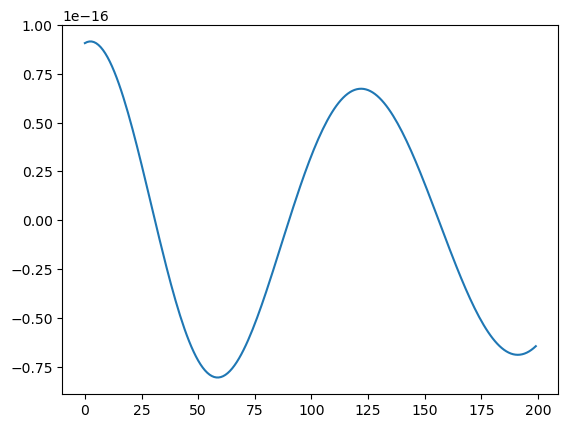

In [62]:
gen_wave = GenerateEMRIWaveform("Pn5AAKWaveform")

# parameters
T = 1/365  # years
dt = 15.0  # seconds
M = 4.15e6
a = 0.999
mu = 5e1-2
p0 = 9.
e0 = 0.1
x0 = 0.5  # notice this is x_I, not Y. The AAK waveform can convert to Y.
qK = np.pi/2  # polar spin angle
phiK = 0.0  # azimuthal viewing angle
qS = np.pi/2 # polar sky angle
phiS = 0.0  # azimuthal viewing angle
dist = 0.000008277 
Phi_phi0 = 0.0
Phi_theta0 = 1.5
Phi_r0 = 0.0

h = gen_wave(
    M,
    mu,
    a,
    p0,
    e0,
    x0,
    dist,
    qS,
    phiS,
    qK,
    phiK,
    Phi_phi0,
    Phi_theta0,
    Phi_r0,
    T=T,
    dt=dt,
)

plt.plot(h.real[:200])

In [75]:
gen_wave = GenerateEMRIWaveform("Pn5AAKWaveform")

T = 15/365
dt = 15.0  # seconds
M = 4.15e6
a = 0.998
mu = 5e-2
p0 = 15.0
e0 = 0.1
x0 = 1.0  # notice this is x_I, not Y. The AAK waveform can convert to Y.
qK = 0 # polar spin angle
phiK = 0.0  # azimuthal viewing angle
qS = np.pi/2 # polar sky angle
phiS = 0.0  # azimuthal viewing angle
dist = 0.000008277 
Phi_phi0 = 0.0
Phi_theta0 = 0.0
Phi_r0 = 0.0

h = gen_wave(
    M,
    mu,
    a,
    p0,
    e0,
    x0,
    dist,
    qS,
    phiS,
    qK,
    phiK,
    Phi_phi0,
    Phi_theta0,
    Phi_r0,
    T=T,
    dt=dt,
)



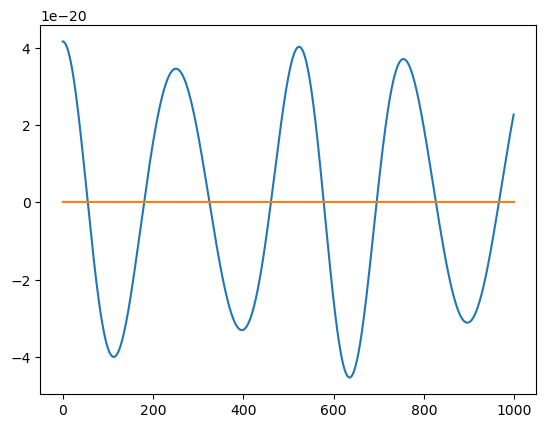

In [76]:
t= np.arange(len(h))* dt  # time array
plt.figure()
plt.plot(h.real[:1000])
plt.plot(h.imag[:1000])
# plt.plot(t,h.imag)
plt.show()

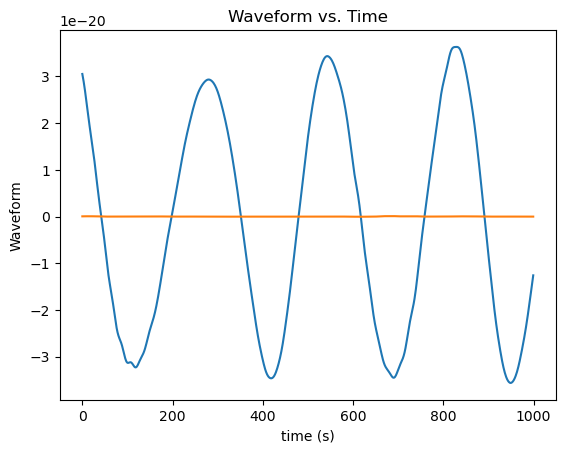

In [77]:
testWave = few(4.15e6, 5e-2, 16, 0.1, np.pi/2, 0, dist=dist, dt=15, T=15/365)
plt.figure()
plt.plot(testWave.real[:1000].get())
plt.plot(testWave.imag[:1000].get())
plt.xlabel('time (s)')
plt.ylabel('Waveform')
plt.title('Waveform vs. Time')
plt.show()


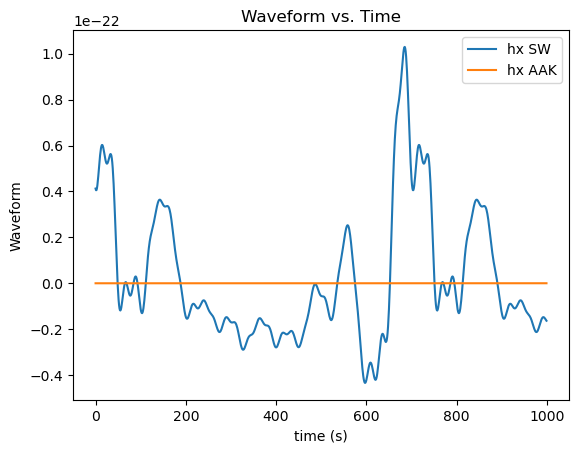

In [78]:
plt.figure()
# plt.plot(testWave.real[:1000].get(), label='h+ SW')
plt.plot(testWave.imag[:1000].get(), label='hx SW')
# plt.plot(h.real[:1000], label='h+ AAK')
plt.plot(h.imag[:1000], label='hx AAK')
plt.xlabel('time (s)')
plt.legend()
plt.ylabel('Waveform')
plt.title('Waveform vs. Time')
plt.show()

Text(0.5, 1.0, 'Waveform vs. Time')

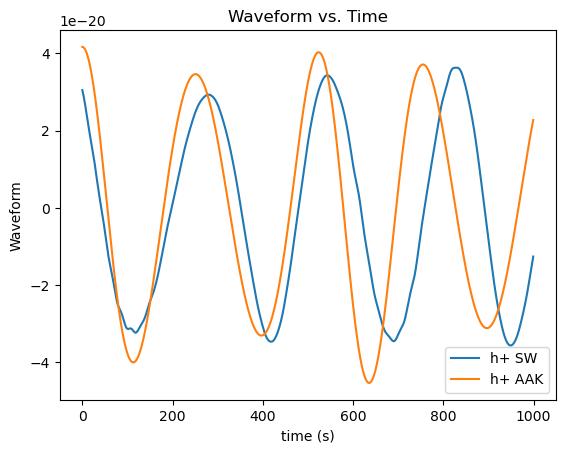

In [186]:
plt.figure()
plt.plot(testWave.real[:1000].get(), label='h+ SW')
# plt.plot(testWave.imag[:1000].get(), label='hx SW')
plt.plot(h.real[:1000] , label='h+ AAK')
# plt.plot(h.imag[:1000], label='hx AAK')
plt.xlabel('time (s)')
plt.legend()
plt.ylabel('Waveform')
plt.title('Waveform vs. Time')

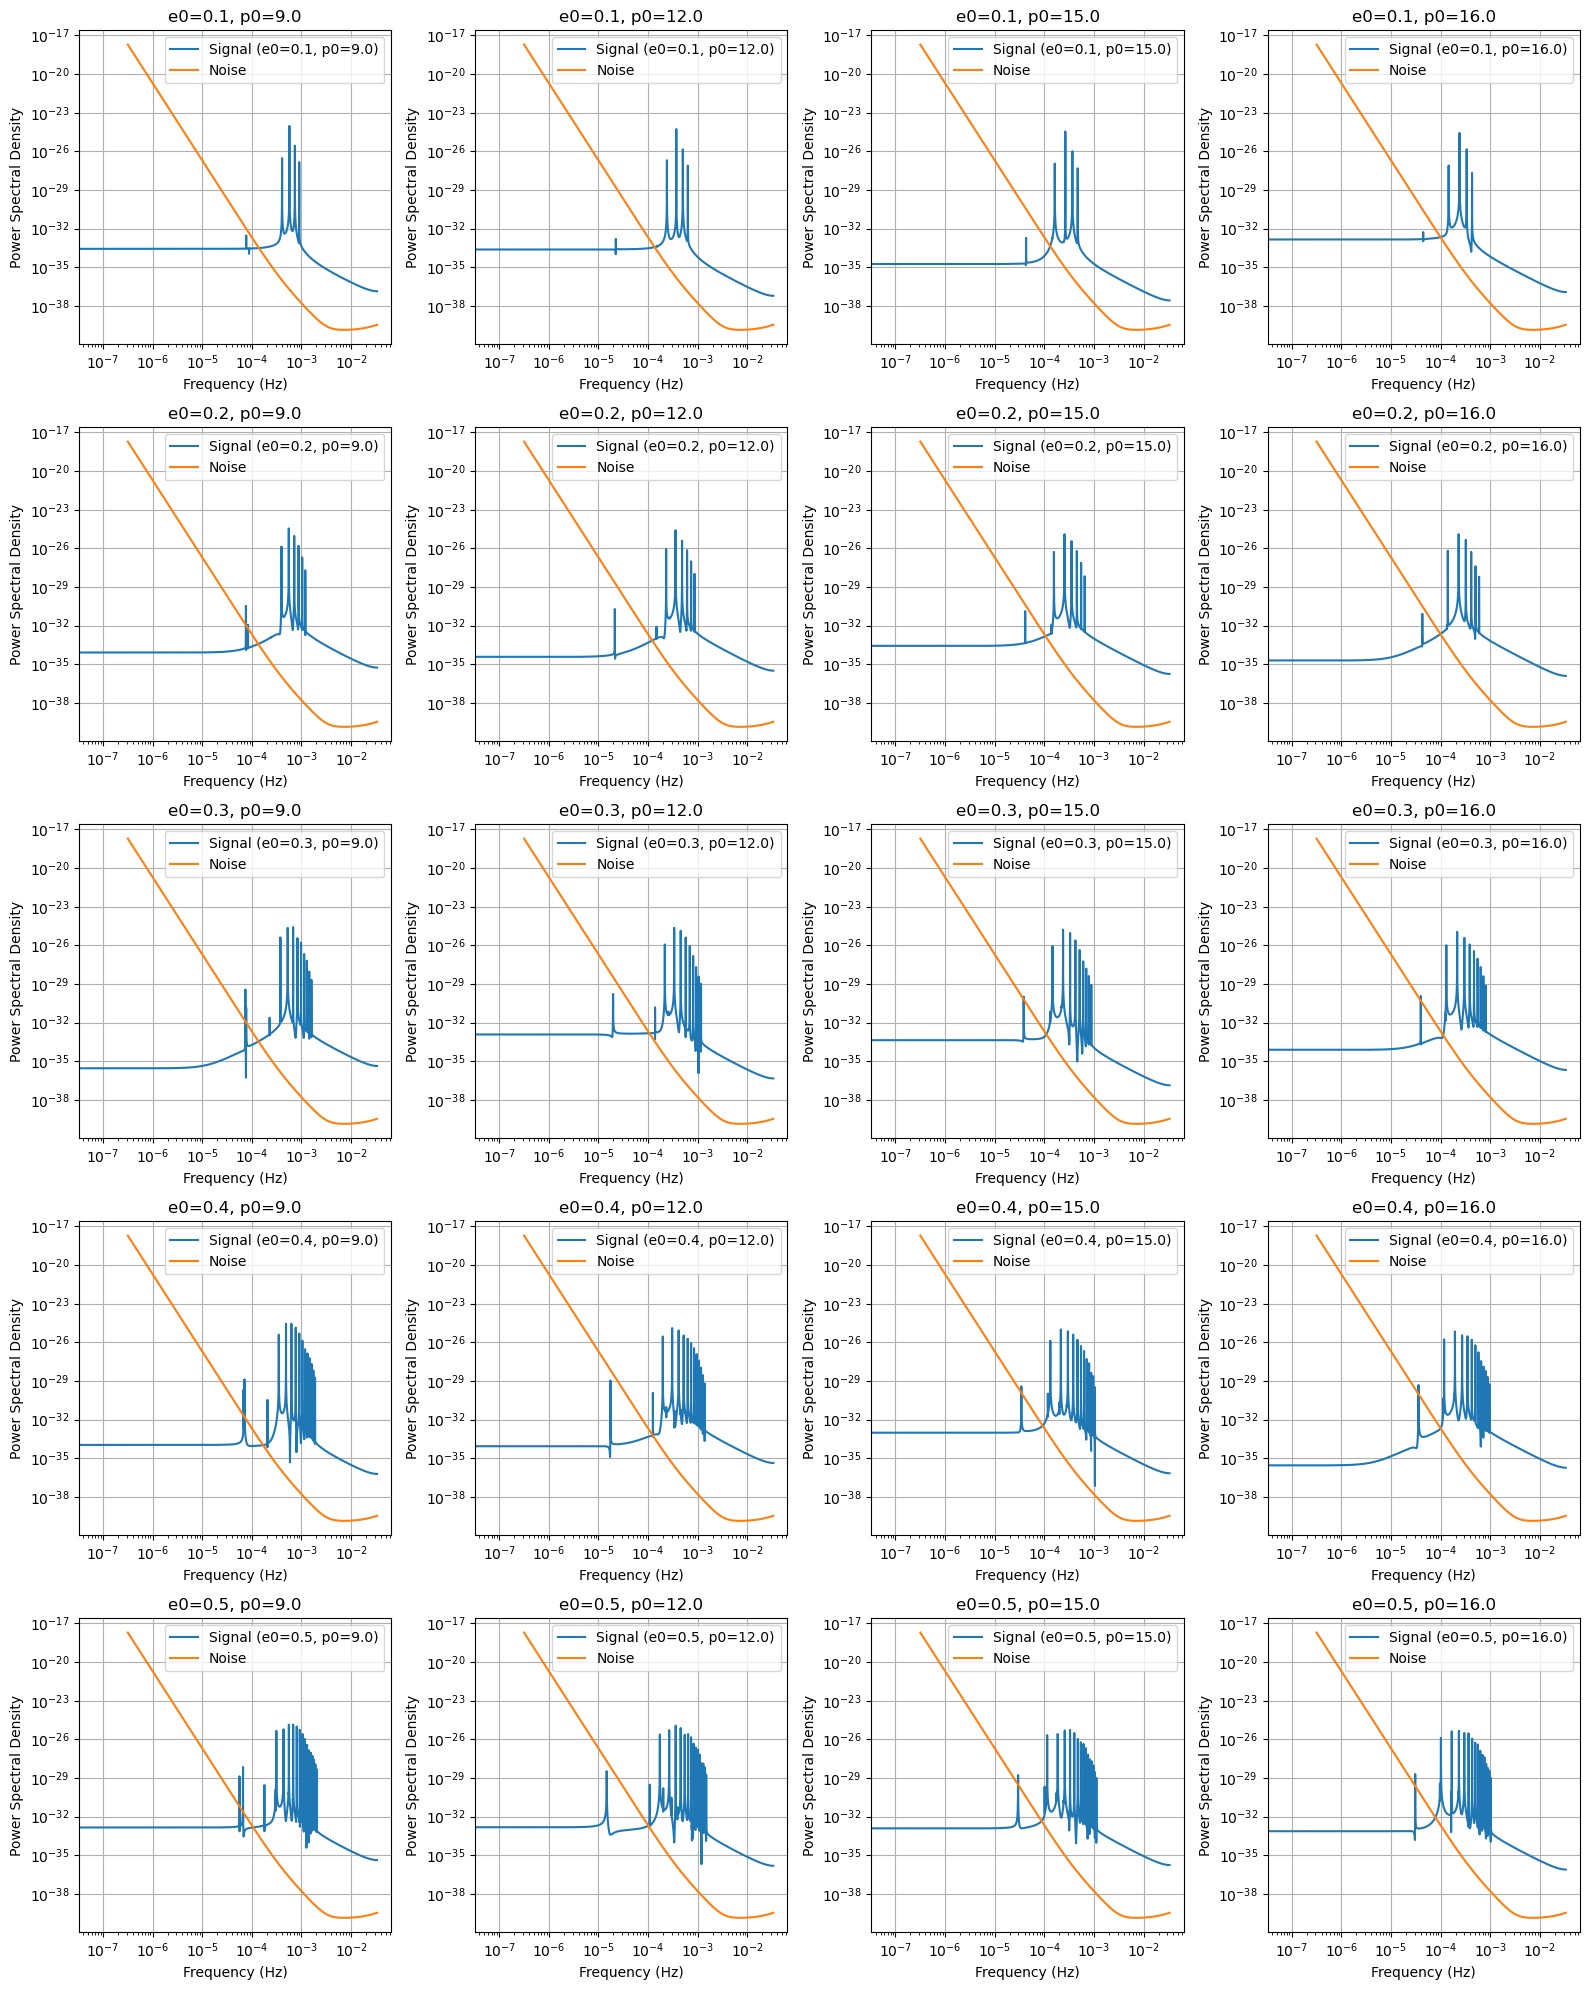

In [23]:
import matplotlib.pyplot as plt

# Create a 5x4 subplot grid
fig, axs = plt.subplots(5, 4, figsize=(16, 20))

# Flatten the 2D array of axes to iterate over them easily
axs = axs.flatten()

# Iterate over each subplot and plot the corresponding data
for i, (e0, p0) in enumerate([(e0, p0) for e0 in [0.1, 0.2, 0.3, 0.4, 0.5] for p0 in [9.0, 12.0, 15.0, 16.0]]):
    ax = axs[i]
    freq, sig = sensitivitYimposed(5e-2, p0, e0, 0.5,0.0)
    if freq is not None and sig is not None:
        ax.loglog(freq.get(), sig.get(), label=f'Signal (e0={e0}, p0={p0})')

    # Adding a separate noise plot for a specific case
    freq, sig = sensitivitYimposed(5e-2, 9.0, 0.7, 0.1,0.0)
    power_spectral_density = power_spectral_density_RCLfit(freq)
    ax.loglog(freq.get(), power_spectral_density.get(), label='Noise')

    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power Spectral Density')
    ax.set_title(f'e0={e0}, p0={p0}')
    ax.legend()
    ax.grid()

# Adjust layout to prevent overlapping titles
plt.tight_layout()
plt.show()


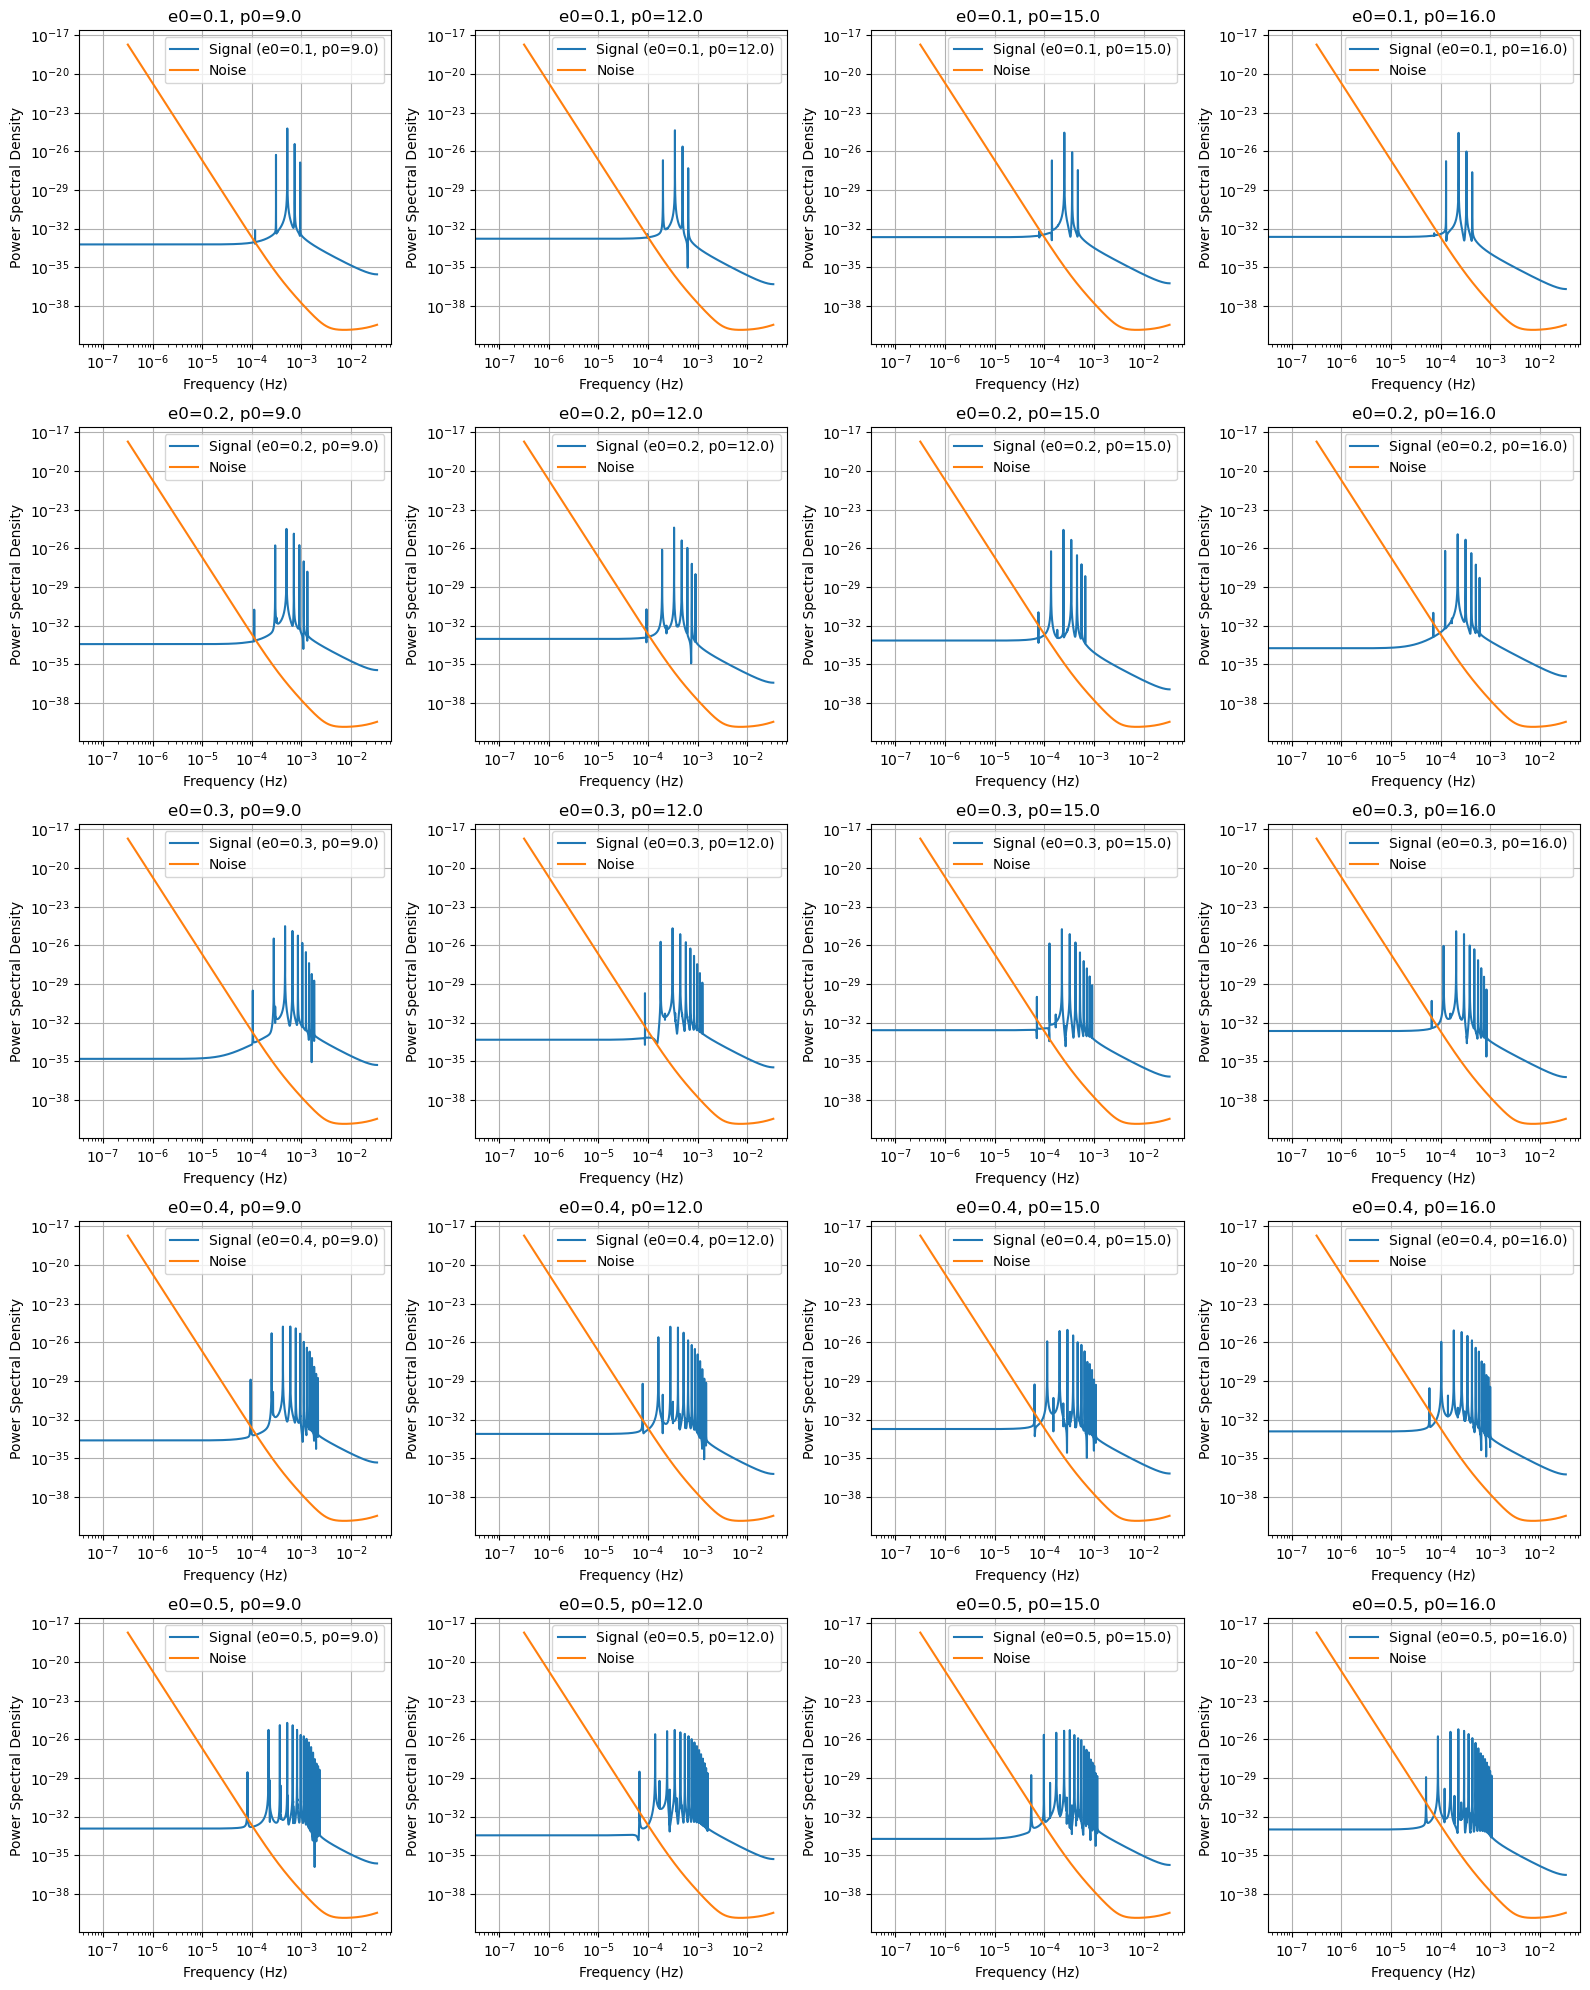

In [25]:
import matplotlib.pyplot as plt
Print("plots for spin = 0.998")
# Create a 5x4 subplot grid
fig, axs = plt.subplots(5, 4, figsize=(16, 20))

# Flatten the 2D array of axes to iterate over them easily
axs = axs.flatten()

# Iterate over each subplot and plot the corresponding data
for i, (e0, p0) in enumerate([(e0, p0) for e0 in [0.1, 0.2, 0.3, 0.4, 0.5] for p0 in [9.0, 12.0, 15.0, 16.0]]):
    ax = axs[i]
    freq, sig = sensitivitYimposed(5e-2, p0, e0, 0.5,0.998)
    if freq is not None and sig is not None:
        ax.loglog(freq.get(), sig.get(), label=f'Signal (e0={e0}, p0={p0})')

    # Adding a separate noise plot for a specific case
    freq, sig = sensitivitYimposed(5e-2, 9.0, 0.7, 0.1,0.998)
    power_spectral_density = power_spectral_density_RCLfit(freq)
    ax.loglog(freq.get(), power_spectral_density.get(), label='Noise')

    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power Spectral Density')
    ax.set_title(f'e0={e0}, p0={p0}')
    ax.legend()
    ax.grid()

# Adjust layout to prevent overlapping titles
plt.tight_layout()
plt.show()


Calulated
Calulated
Calulated
Calulated
Calulated
Calulated
Calulated
Calulated
Calulated


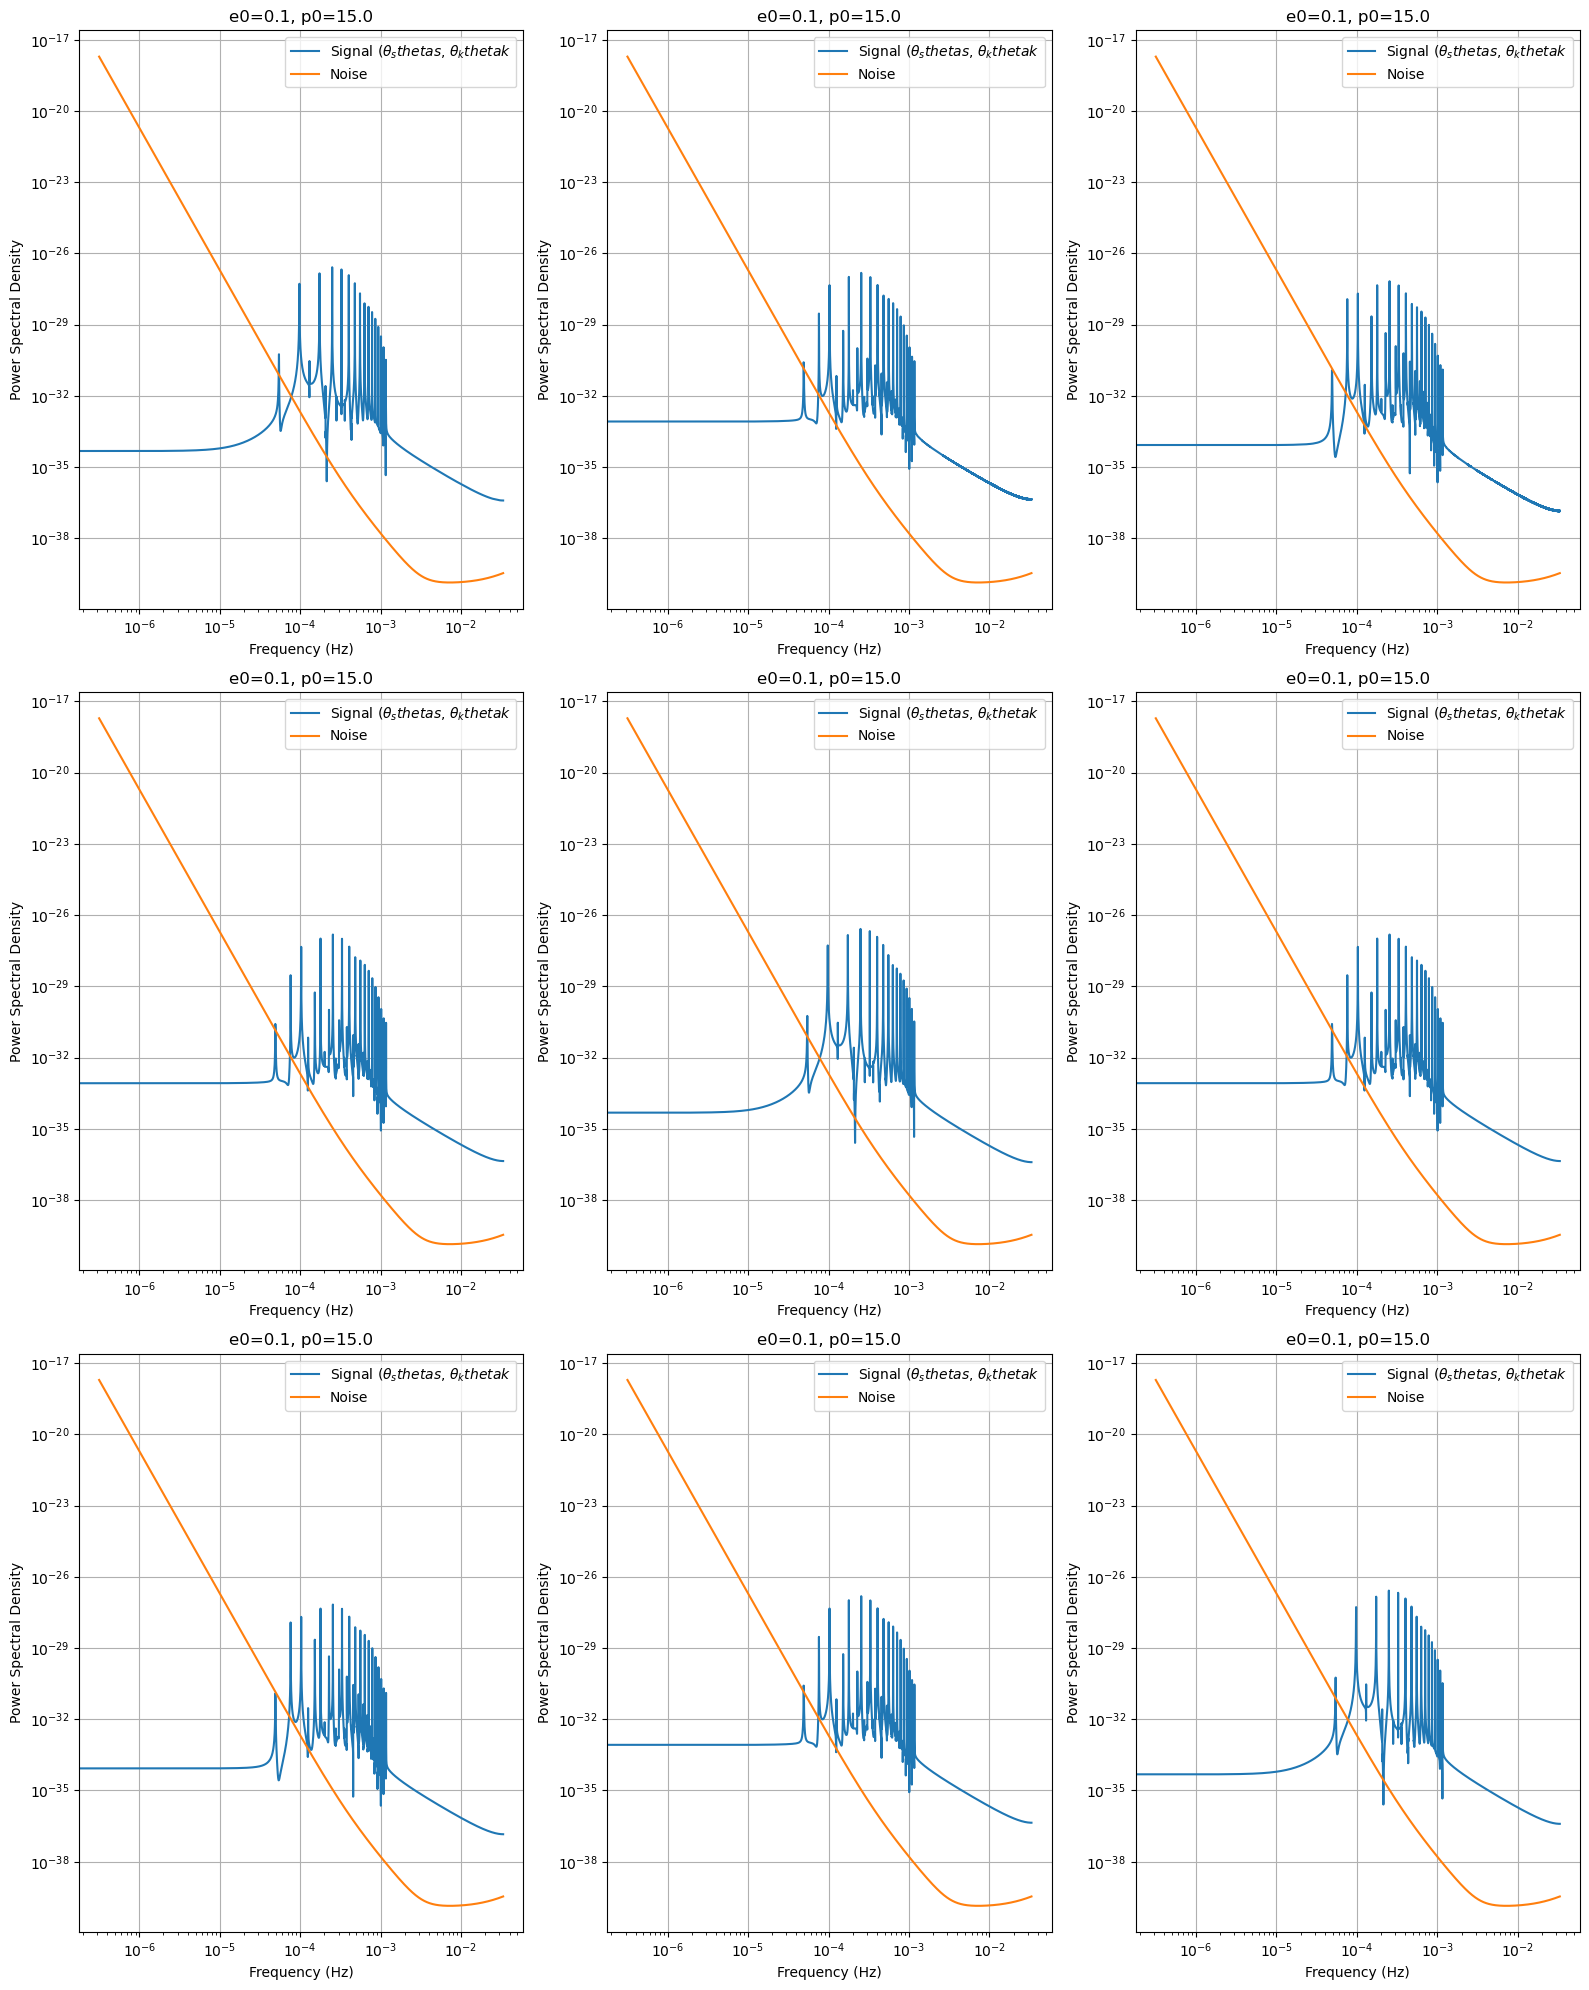

In [86]:
import matplotlib.pyplot as plt

# Create a 5x4 subplot grid
fig, axs = plt.subplots(3, 3, figsize=(16, 20))

# Flatten the 2D array of axes to iterate over them easily
axs = axs.flatten()

# Iterate over each subplot and plot the corresponding data
for i, (thetak, thetas) in enumerate([(thetak, thetas) for thetak in [0.0, np.pi/4, np.pi/2] for thetas in [0.0, np.pi/4, np.pi/2]]):
    ax = axs[i]
    freq, sig = sensitivitYimposedOnAngles(5e-2, 15.0, 0.5, 0.1,0.998,thetas,0.0,thetak,0.0)
    print ('Calulated')
    if freq is not None and sig is not None:
        ax.loglog(freq.get(), sig.get(), label=r'Signal ($\theta_s{thetas}$, $\theta_k{thetak}$')

    # Adding a separate noise plot for a specific case
    freq, sig = sensitivitYimposed(5e-2, 9.0, 0.7, 0.1,0.998)
    power_spectral_density = power_spectral_density_RCLfit(freq)
    ax.loglog(freq.get(), power_spectral_density.get(), label='Noise')

    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power Spectral Density')
    ax.set_title(f'e0={e0}, p0={p0}')
    ax.legend()
    ax.grid()

# Adjust layout to prevent overlapping titles
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Create a 5x4 subplot grid
fig, axs = plt.subplots(3, 3, figsize=(16, 20))

# Flatten the 2D array of axes to iterate over them easily
axs = axs.flatten()

# Iterate over each subplot and plot the corresponding data
for i, (thetak, thetas) in enumerate([(thetak, thetas) for thetak in [0.0, np.pi/4, np.pi/2] for thetas in [0.0, np.pi/4, np.pi/2]]):
    ax = axs[i]
    freq, sig = sensitivitYimposedOnAngles(5e-2, 15.0, 0.5, 0.1,0.998,thetas,0.0,thetak,0.0)
    print ('Calulated')
    if freq is not None and sig is not None:
        ax.loglog(freq.get(), sig.get(), label=f'Signal ($\theta_s{thetas}$, $\theta_k{thetak}$')

    # Adding a separate noise plot for a specific case
    freq, sig = sensitivitYimposed(5e-2, 9.0, 0.7, 0.1,0.998)
    power_spectral_density = power_spectral_density_RCLfit(freq)
    ax.loglog(freq.get(), power_spectral_density.get(), label='Noise')

    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power Spectral Density')
    ax.set_title(f'e0={e0}, p0={p0}')
    ax.legend()
    ax.grid()

# Adjust layout to prevent overlapping titles
plt.tight_layout()
plt.show()


In [83]:
def snrRev(r): 
    T = .2
    dt = 15.0  # seconds
    M = 4.15e6
    a = 0.998
    mu =5e-2
    p0 =r
    e0 = 0.75
    x0 = 1.0  # notice this is x_I, not Y. The AAK waveform can convert to Y.
    qK = 0  # polar spin angle
    phiK = np.pi/2 # azimuthal viewing angle
    qS = 0 # polar sky angle
    phiS = 0  # azimuthal viewing angle
    dist = 0.000008277 
    Phi_phi0 = 0.0
    Phi_theta0 = 0.0
    Phi_r0 = 0.0

    h = gen_wave(
        M,
        mu,
        a,
        p0,
        e0,
        x0,
        dist,
        qS,
        phiS,
        qK,
        phiK,
        Phi_phi0,
        Phi_theta0,
        Phi_r0,
        T=T,
        dt=dt,
    )
    fft_TD = np.fft.fftshift(np.fft.fft(h.real)) * dt
    fft_TDX = np.fft.fftshift(np.fft.fft(h.imag)) * dt
    freq = np.fft.fftshift(np.fft.fftfreq(len(h.real) , dt))
    positive_frequency_mask = (freq>=0.0)
    a1= freq[positive_frequency_mask]
    b1=np.abs(fft_TD[positive_frequency_mask])**2
    # wave5 = few(M, mu, r, 0, theta, phi, dist=dist1, dt=dt, T=15/365)
    # fft_TD = np.fft.fftshift(np.fft.fft(wave5.real)) * dt
    # fft_TDX = np.fft.fftshift(np.fft.fft(wave5.imag)) * dt
    # freq = np.fft.fftshift(np.fft.fftfreq(len(wave5.real), dt))

    pluspart = np.abs(fft_TD)**2
    crosspart = np.abs(fft_TDX)**2
    df = freq[1] - freq[0]
    integralp = np.zeros(len(pluspart))
    numerator = pluspart + crosspart
    denominator = power_spectral_density_RCLfit(freq)
    
    for i in range(len(numerator)):
        integralp[i] = numerator[i] / denominator[i]
    
    snr = np.sqrt((4 * np.sum(integralp) * df))
    return float(snr)


In [84]:

r = np.linspace(9.0, 16.0, 50)
snr = []

for r_val in r:
    snr.append(snrRev(r_val))

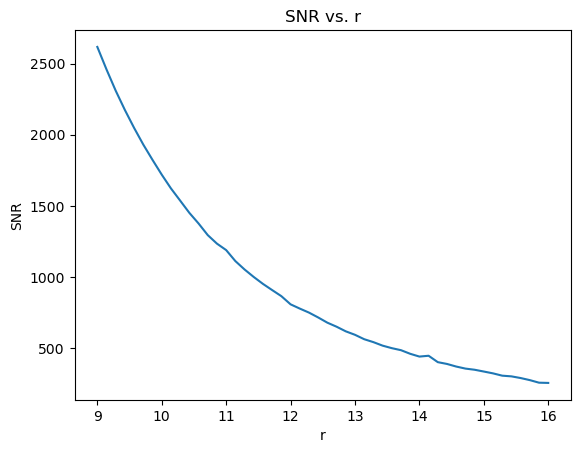

In [85]:
plt.figure()
plt.plot(r, snr)
plt.xlabel('r')
plt.ylabel('SNR')
plt.title('SNR vs. r')
plt.show()


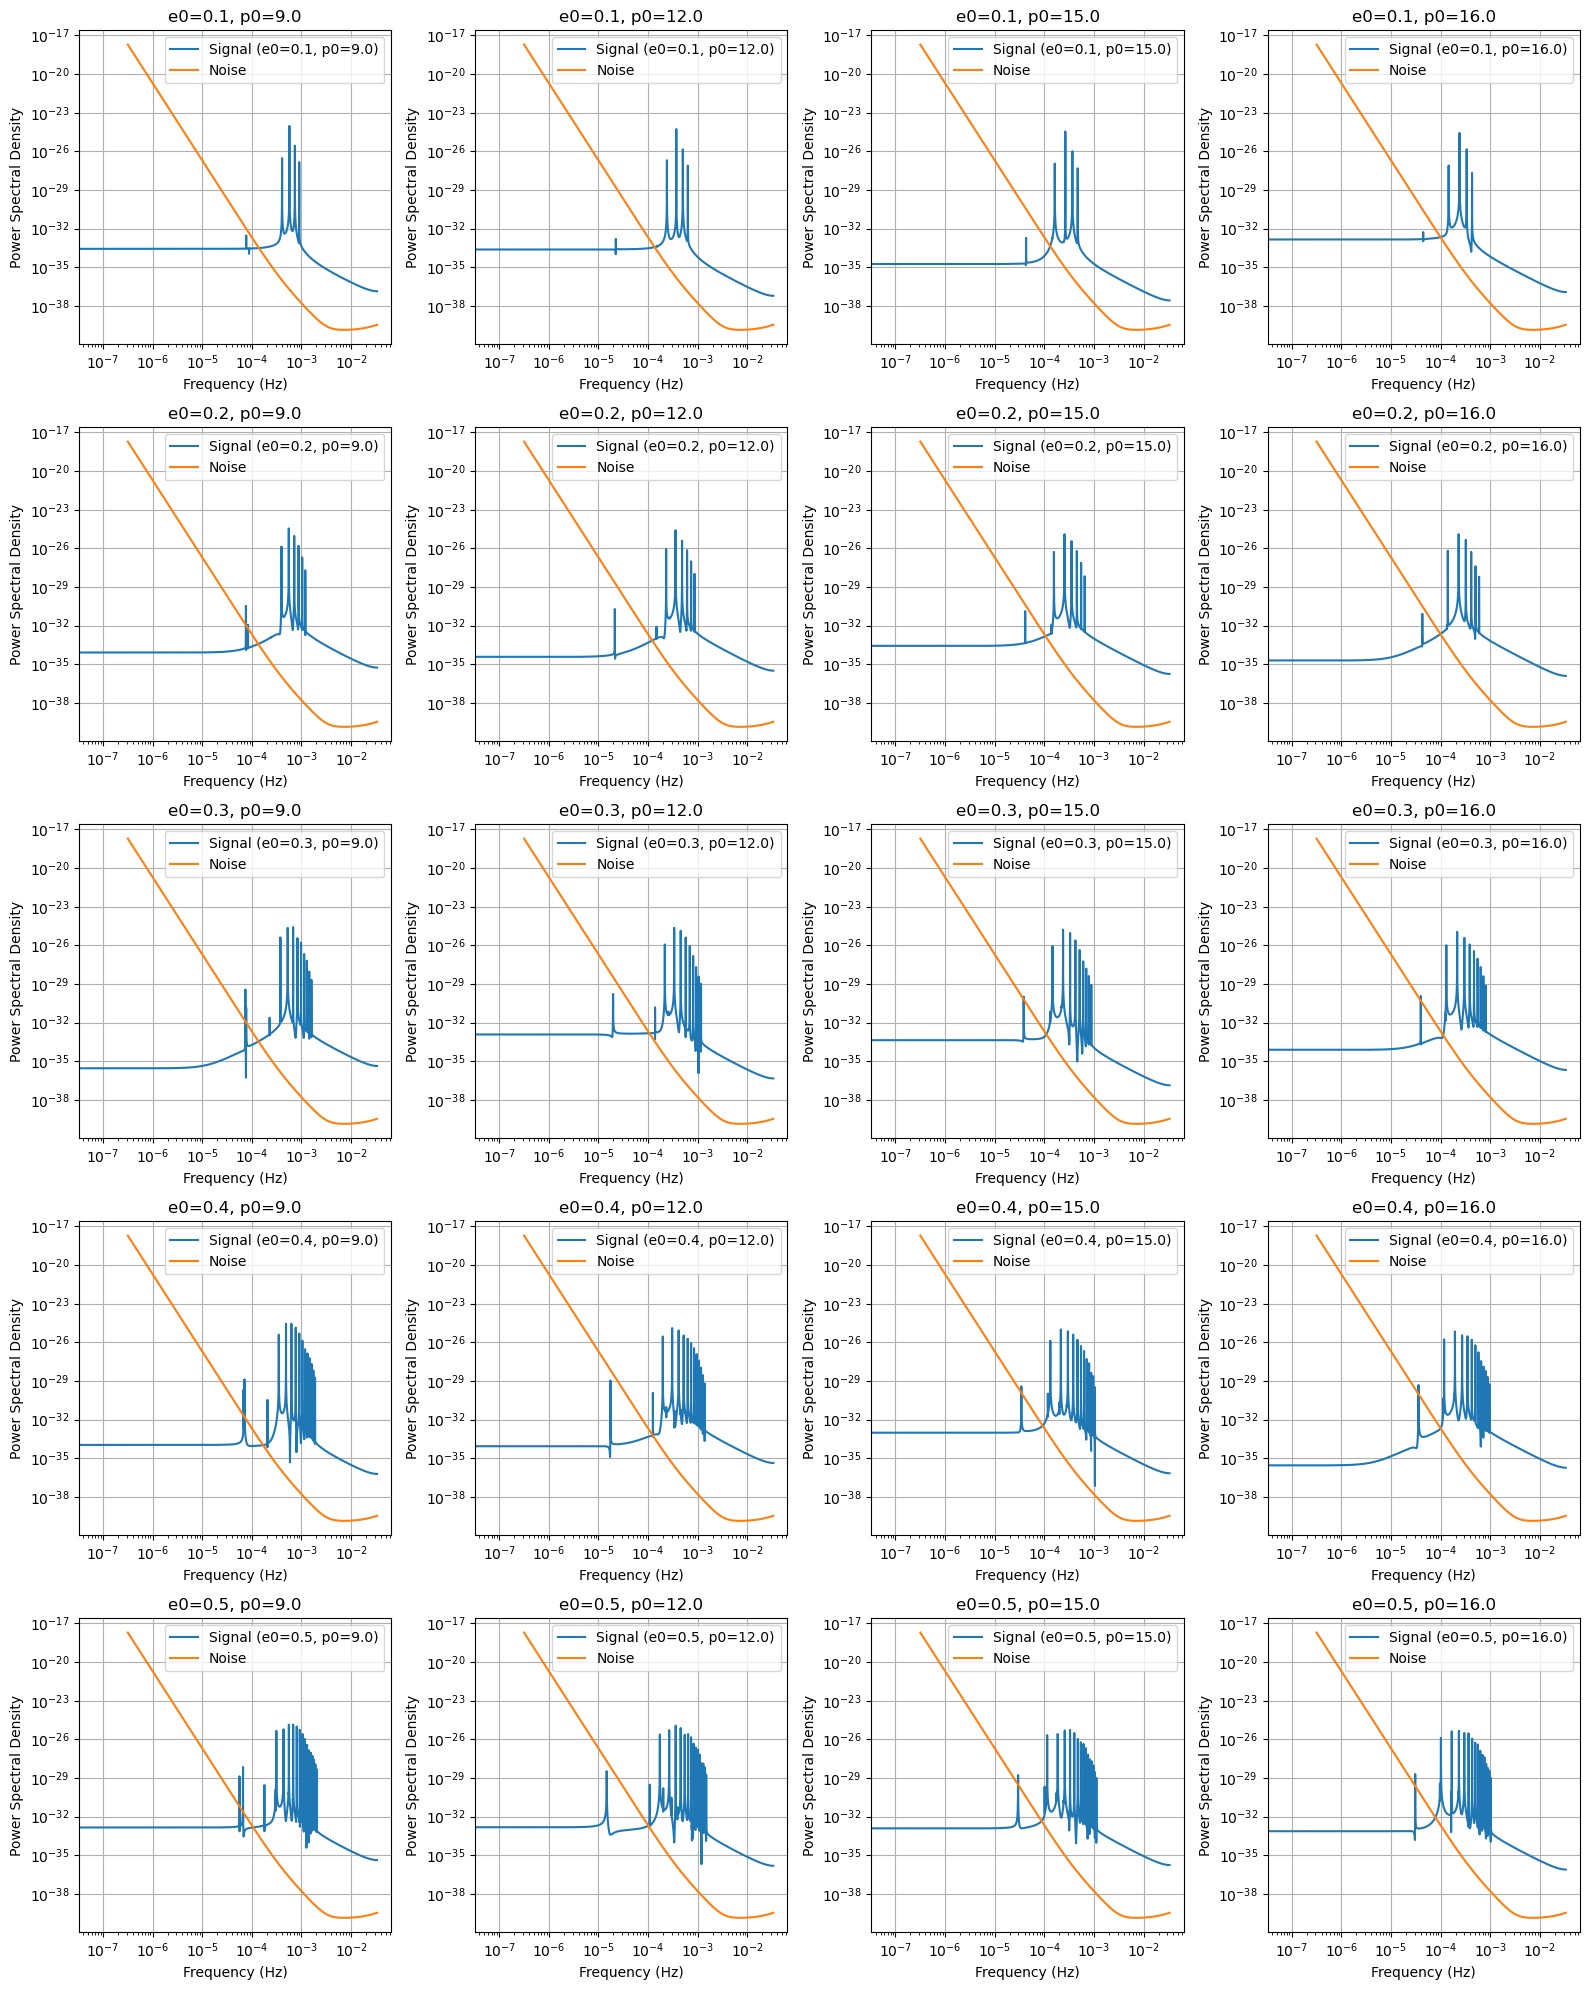

In [111]:
import matplotlib.pyplot as plt

# Create a 5x4 subplot grid
fig, axs = plt.subplots(5, 4, figsize=(16, 20))

# Flatten the 2D array of axes to iterate over them easily
axs = axs.flatten()

# Iterate over each subplot and plot the corresponding data
for i, (e0, p0) in enumerate([(e0, p0) for e0 in [0.1, 0.2, 0.3, 0.4, 0.5] for p0 in [9.0, 12.0, 15.0, 16.0]]):
    ax = axs[i]
    freq, sig = sensitivitYimposed(5e-2, p0, e0, 0.5,0.0)
    if freq is not None and sig is not None:
        ax.loglog(freq.get(), sig.get(), label=f'Signal (e0={e0}, p0={p0})')

    # Adding a separate noise plot for a specific case
    freq, sig = sensitivitYimposed(5e-2, 9.0, 0.7, 0.1,0.0)
    power_spectral_density = power_spectral_density_RCLfit(freq)
    ax.loglog(freq.get(), power_spectral_density.get(), label='Noise')

    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power Spectral Density')
    ax.set_title(f'e0={e0}, p0={p0}')
    ax.legend()
    ax.grid()

# Adjust layout to prevent overlapping titles
plt.tight_layout()
plt.show()

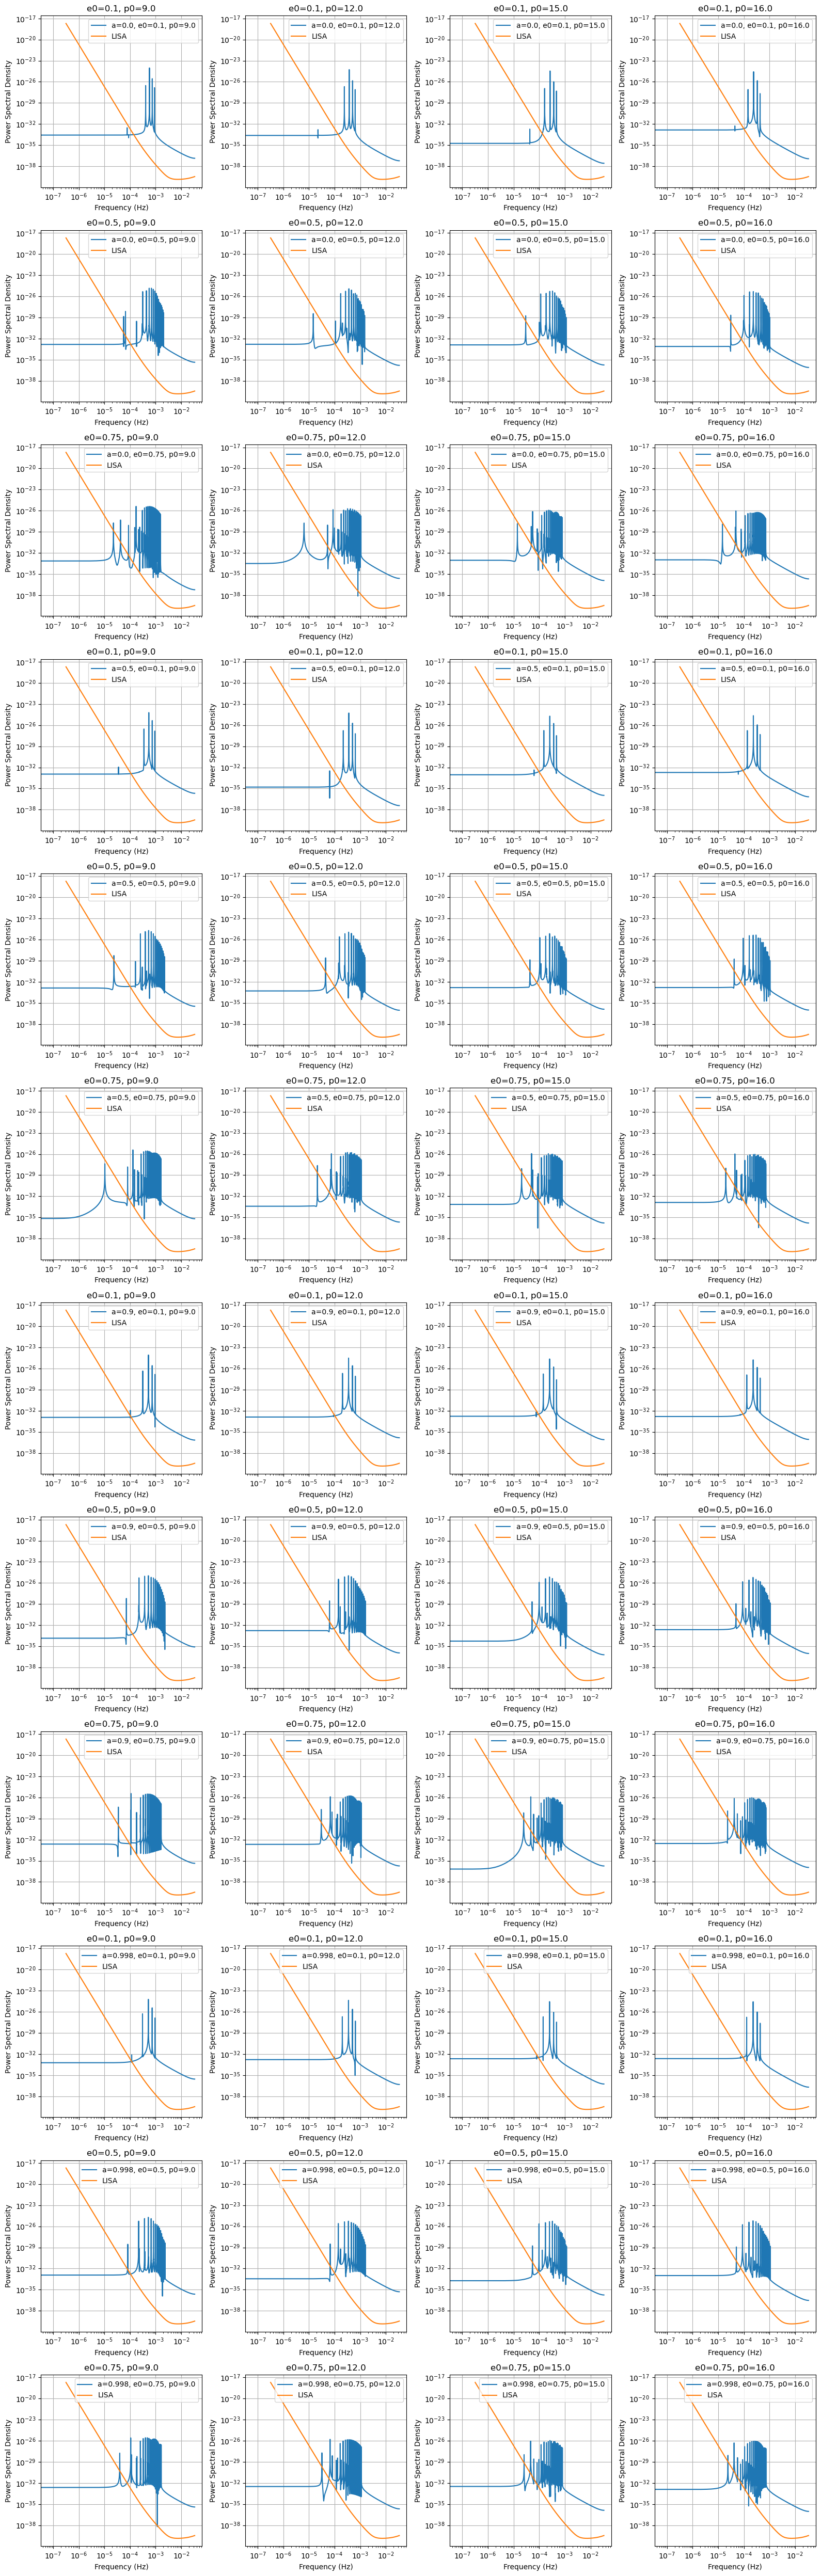

In [191]:
import matplotlib.pyplot as plt

# Create a 5x4 subplot grid
fig, axs = plt.subplots(12, 4, figsize=(16, 50))

# Flatten the 2D array of axes to iterate over them easily
axs = axs.flatten()
for i, a  in enumerate( [0.0, 0.5, 0.9, 0.998]) :
# Iterate over each subplot and plot the corresponding data
    for j, (e0, p0) in enumerate([(e0, p0) for e0 in [0.1, 0.5, 0.75] for p0 in [9.0, 12.0, 15.0, 16.0]]):
        ax = axs[i*12+j]
        freq, sig = sensitivitYimposed(5e-2, p0, e0, 0.5,a)
        if freq is not None and sig is not None:
            ax.loglog(freq.get(), sig.get(), label=f'a={a}, e0={e0}, p0={p0}')

        # Adding a separate noise plot for a specific case
        freq, sig = sensitivitYimposed(5e-2, 9.0, 0.7, 0.1,0.0)
        power_spectral_density = power_spectral_density_RCLfit(freq)
        ax.loglog(freq.get(), power_spectral_density.get(), label='LISA')

        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel('Power Spectral Density')
        ax.set_title(f'e0={e0}, p0={p0}')
        ax.legend()
        ax.grid()

# Adjust layout to prevent overlapping titles
plt.tight_layout()
plt.show()

In [189]:
gen_wave = GenerateEMRIWaveform("Pn5AAKWaveform")

def overlap(qS):

    T = 15/365
    dt = 15.0  # seconds
    M = 4.15e6
    a = 0.998
    mu = 5e-2
    p0 = 15.0
    e0 = 0.1
    x0 = 1.0  # notice this is x_I, not Y. The AAK waveform can convert to Y.
    qK = 0 # polar spin angle
    phiK = 0.0  # azimuthal viewing angle
    qS = qS # polar sky angle
    phiS = 0.0  # azimuthal viewing angle
    dist = 0.000008277 
    Phi_phi0 = 0.0
    Phi_theta0 = 0.0
    Phi_r0 = 0.0

    h1 = gen_wave(
        M,
        mu,
        a,
        p0,
        e0,
        x0,
        dist,
        qS,
        phiS,
        qK,
        phiK,
        Phi_phi0,
        Phi_theta0,
        Phi_r0,
        T=T,
        dt=dt,
    )

    h2 = gen_wave(
        M,
        mu,
        0.998,
        p0,
        0.7,
        x0,
        dist,
        qS,
        phiS,
        qK,
        phiK,
        Phi_phi0,
        Phi_theta0,
        Phi_r0,
        T=T,
        dt=dt,
    )
    plt.figure()
    plt.plot(h1.real[:3000], label='e=0.1')
    plt.plot(h2.real [:3000],label='e=0.7')
    plt.legend()
    plt.xlabel('time (s)')
    plt.ylabel('Waveform')
    plt.title('Waveform vs. Time at qS = '+str(qS))
    plt.show()

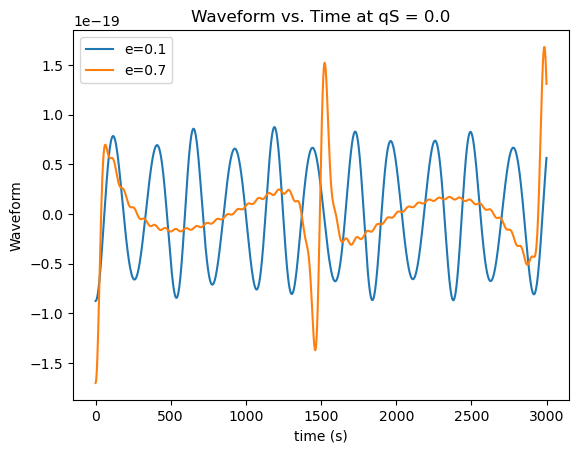

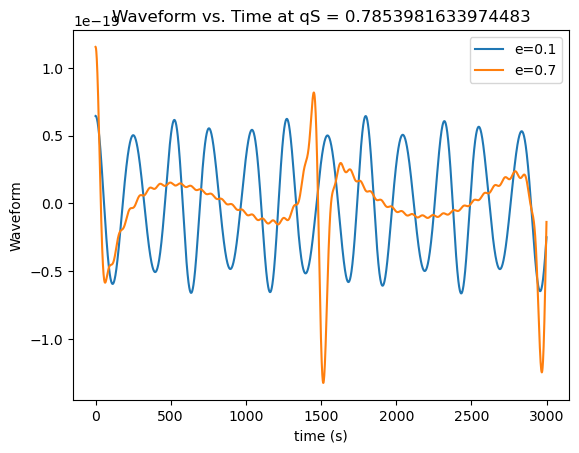

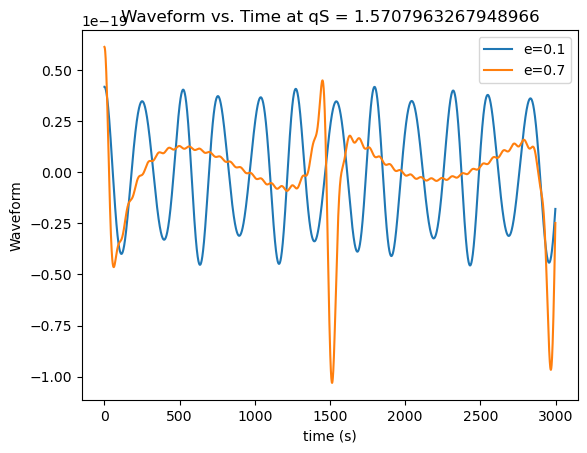

In [190]:
overlap(0.0)
overlap(np.pi/4)
overlap(np.pi/2)


In [181]:
gen_wave = GenerateEMRIWaveform("Pn5AAKWaveform")

T = 15/365
dt = 15.0  # seconds
M = 4.15e6
a = 0.0
mu = 5e-2
p0 = 15.0
e0 = 0.1
x0 = 1.0  # notice this is x_I, not Y. The AAK waveform can convert to Y.
qK = 0 # polar spin angle
phiK = 0.0  # azimuthal viewing angle
qS = np.pi/4# polar sky angle
phiS = 0.0  # azimuthal viewing angle
dist = 0.000008277 
Phi_phi0 = 0.0
Phi_theta0 = 0.0
Phi_r0 = 0.0

h4 = gen_wave(
    M,
    mu,
    a,
    p0,
    e0,
    x0,
    dist,
    qS,
    phiS,
    qK,
    phiK,
    Phi_phi0,
    Phi_theta0,
    Phi_r0,
    T=T,
    dt=dt,
)

h3 = gen_wave(
    M,
    mu,
    0.998,
    p0,
    0.6,
    x0,
    dist,
    qS,
    phiS,
    qK,
    phiK,
    Phi_phi0,
    Phi_theta0,
    Phi_r0,
    T=T,
    dt=dt,
)

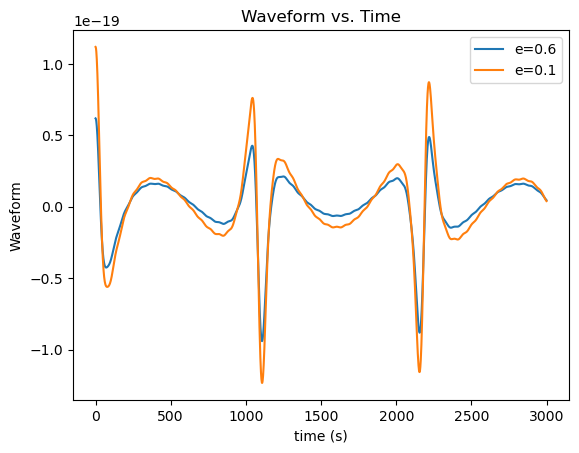

In [185]:
plt.figure()
# plt.plot(h1.real[:3000], label='e=0.1')
plt.plot(h2.real [:3000],label='e=0.6')
plt.plot(h3.real[:3000], label='e=0.1')
# plt.plot(h4.real [:3000],label='e=0.6')

plt.legend()
plt.xlabel('time (s)')
plt.ylabel('Waveform')
plt.title('Waveform vs. Time')
plt.show()
